In [2]:
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
# importing data form the source directory in google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
#data_dir = '/content/drive/MyDrive/JPM_QR/'
data_file = 'Nat_Gas.csv'
#natgas = pd.read_csv(data_dir + data_file)
natgas = pd.read_csv(data_file)

In [5]:
natgas.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [6]:
natgas.tail()

,Dates,Prices
43,5/31/24,11.4
44,6/30/24,11.5
45,7/31/24,11.6
46,8/31/24,11.5
47,9/30/24,11.8


In [7]:
natgas.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [8]:
natgas.shape

(48, 2)

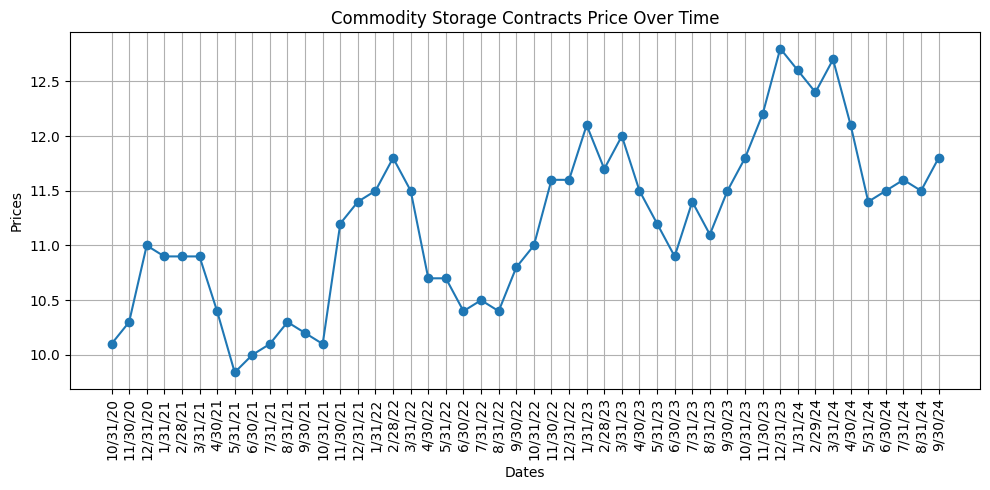

In [ ]:
# Visualize the data
plt.figure(figsize=(10, 5))
plt.plot(natgas['Dates'], natgas['Prices'], marker='o')
plt.title('Commodity Storage Contracts Price Over Time')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(rotation=90)  # Rotate the x-axis labels vertically
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# Preprocess the data - Ensure correct data type
natgas['Dates'] = pd.to_datetime(natgas['Dates'])
natgas.set_index('Dates', inplace=True, verify_integrity=True)

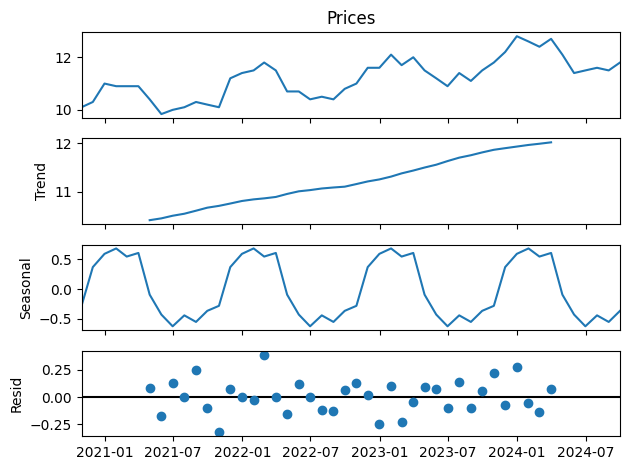

In [ ]:
# Seasonal decomposition to find patterns
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(natgas['Prices'], model='additive')
result.plot()
plt.tight_layout()
plt.show()

In [ ]:
# Use auto_arima to find the best ARIMA model for our time series
stepwise_model = auto_arima(natgas['Prices'],
                            start_p=1,
                            start_q=1,
                            max_p=3,
                            max_q=3,
                            m=12,
                            start_P=0,
                            seasonal=True,
                            d=1,
                            D=1,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=36.460, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=21.605, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=25.917, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=34.778, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=15.104, Time=0.17 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=19.665, Time=0.11 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8.260, Time=0.58 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.83 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(

In [ ]:
# Fit the model
stepwise_model.fit(natgas['Prices'])

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
# Future forecasting
future_periods = 12  # Months to forecast into the future
forecast = stepwise_model.predict(n_periods=future_periods)

In [ ]:
# Convert the forecast into a DataFrame
future_dates = pd.date_range(start=natgas.index[-1], periods=future_periods + 1, freq='MS')[1:]
forecast_df = pd.DataFrame({'Dates': future_dates, 'Predicted_Prices': forecast})

In [ ]:
def forecast_price(input_date):
    # Convert input_date to pandas datetime object
    input_date = pd.to_datetime(input_date)

    # Get the last date from the data
    last_date = natgas.index[-1]

    # Calculate the difference between the input date and the last date in months
    delta = (input_date.year - last_date.year) * 12 + input_date.month - last_date.month

    # If input_date is before the start of our data, we can't forecast it
    if delta < 0:
        raise ValueError(f"Can't forecast a date earlier than the dataset: {last_date}")

    # Predict the price using the model
    price_on_input_date = stepwise_model.predict(n_periods=delta + 1)[-1]

    return price_on_input_date

In [ ]:
user_date = input("Enter a date (YYYY-MM-DD): ")

# Input validation
try:
  user_date = datetime.datetime.strptime(user_date, "%Y-%m-%d").date()
except ValueError:
  print("Invalid date")
else:
  print("The user entered the date", user_date)

Enter a date (YYYY-MM-DD): 2024-12-12
The user entered the date 2024-12-12


In [ ]:
# Output
input_date = user_date
predicted_price = forecast_price(input_date)
print(f"Predicted price on {input_date}: {predicted_price}")

Predicted price on 2024-12-12: 12.937272133266173


In [ ]:
def estimate_prices_on_dates(dates):
    # Assuming 'forecast_price' is a function from the previous steps that estimates price on a given date
    return [forecast_price(date) for date in dates]

In [ ]:
def calculate_cash_flows(injection_dates, withdrawal_dates, injection_rate, withdrawal_rate, volume_limit, storage_cost):
    # Get the prices for injection and withdrawal dates
    injection_prices = estimate_prices_on_dates(injection_dates)
    withdrawal_prices = estimate_prices_on_dates(withdrawal_dates)

    # Calculate the cost of injections and the revenue from withdrawals
    total_injection_cost = sum(injection_rate * price for price in injection_prices)
    total_withdrawal_revenue = sum(withdrawal_rate * price for price in withdrawal_prices)

    # Ensure the volume limit is not exceeded
    total_volume_injected = len(injection_dates) * injection_rate
    if total_volume_injected > volume_limit:
        raise ValueError("Injected volume exceeds the maximum storage volume limit.")

    # Calculate net cash flow
    net_cash_flow = total_withdrawal_revenue - total_injection_cost - storage_cost

    return net_cash_flow

In [ ]:
def price_storage_contract(injection_dates, withdrawal_dates, injection_rate, withdrawal_rate, volume_limit, storage_cost):
    # Calculate the contract value
    contract_value = calculate_cash_flows(injection_dates, withdrawal_dates, injection_rate, withdrawal_rate, volume_limit, storage_cost)
    return contract_value

In [ ]:
# Sample data
injection_dates = ['2025-04-01', '2025-05-01', '2025-06-01']
withdrawal_dates = ['2025-07-01', '2025-08-01', '2025-09-01']
injection_rate = 1000  # Assuming this is the rate in units per date
withdrawal_rate = 1000  # Assuming this is the rate in units per date
volume_limit = 5000  # The maximum volume that can be stored
storage_cost = 10000  # Total storage cost for the period

# Estimate the contract value
contract_value = price_storage_contract(injection_dates, withdrawal_dates, injection_rate, withdrawal_rate, volume_limit, storage_cost)
print(f"The estimated value of the storage contract is: {contract_value}")

The estimated value of the storage contract is: -9410.682179872769
